# Lunar Lander

### References

- [Lunar Lander Gym](https://www.gymlibrary.dev/environments/box2d/lunar_lander/)
- [DEAP documentation](https://deap.readthedocs.io/en/master/index.html)
- [Inspirational repository](https://github.com/wfleshman/PID_Control)


### Imports for this lesson

In [13]:
# for lunar lander
import gymnasium as gym
from time import sleep
# array manipulation
import numpy as np
# for plots
import matplotlib.pyplot as plt
# for GA
from deap import base, creator, tools, algorithms
import random

## Description of the problem

The goal is to land the shuttle safely in a safe zone.

<img src="https://www.gymlibrary.dev/_images/lunar_lander.gif" width="400" align="center">



### Observation space

At each timestep the lander has access to its current state, consisting of
- the coordinates of the lander in $x$ and $y$;
- the coordinates of its linear velocity in $x$ and $y$;
- its angle;
- its angular velocity;
-  two booleans that represent whether each leg is in contact with the ground or not (touch sensors on each leg).

### PID controller

A Proportional Integrative Derivative (PID) Controller continously calculate an error value $e(t)$ as the difference between a desired setpoint (SP) and a measured process variable (PV). The controller attempts to minimize the error over time by adjustment of a control variable  $a(t)$ of the form
$$a(t) := K_p e(t) + K_i \int_0^t e(\tau) d\tau + K_d \frac{\textrm{d}e(t)}{\textrm{d}t}.$$

In our setting, PV are the altitude and the angle of the lander. The SP is composed by:
- an altitude setpoint equal to $|x_{p}|$, where $x_p$ is the $x$-coordinate of the actual position of the lander. This coincides with the horizontal distance to the target.
- an angle setpoint equal to $\frac{\pi}{4}(x_p + v_x)$, where $v_x$ is the $x$-coordinate of the velocity of the lander.

In our case, the PID controller is actually a PD controller, since the I component is not needed.

In [5]:
def pid(state, params):
    """ Calculates settings based on PID control. 

    Args:
        state (list): 8-element list of the current space, containing respectively the
        x and y coordinates of the lander, x and y coordinates of its velocity, its
        angle, its angular velocity and finally two booleans representing the touch
        sensors on each leg.
        params (list): 4-element list of the current PID parameters, respectively the
        proportional and derivative altitude and the proportional and derivative
        angle.
    
    Returns:
        (np.array) the current action.
    """
    #PID PARAMETERS
    # proportional altitude
    kp_y = params[0] 
    # derivative altitude
    kd_y = params[1]
    # proportional angle
    kp_angle = params[2]  
    # derivative angle
    kd_angle = params[3] 

    # CURRENT SPACE PARAMETERS
    # x-coordinate of the lander
    x_p = state[0]
    # y-coordinate of the lander
    y_p = state[1]
    # x-coordinate of the velocity
    v_x = state[2]
    # y-coordinate of the velocity
    v_y = state[3]
    # angle of the lander
    angle = state[4]
    # angular velocity
    omega = state[5]
    # touch sensors
    touch_sensor_1 = state[6]
    touch_sensor_2 = state[7]
    
    # calculate setpoints (target values)
    y_target = np.abs(x_p)
    angle_target = (np.pi/4)*(x_p + v_x)

    # calculate error values
    y_error = (y_target - y_p)
    angle_error = (angle_target - angle)
    
    # compute a(t) = [a_y(t), a_angle(t)]
    a_y = kp_y*y_error + kd_y*v_y
    a_angle = kp_angle*angle_error + kd_angle*omega
        
    # gym wants them as a np.array in which each entry
    # belongs to the interval [-1,1]
    a = np.array([a_y, a_angle])
    a = np.clip(a, -1, +1)
    
    # If the legs are on the ground we made it, kill engines
    if(touch_sensor_1 or touch_sensor_2):
        a[:] = 0   
    return a

## Optimize PID parameters via Genetic Algorithms

We have to optimize the four PID parameters, i.e. $$[k_p^y, k_p^{\text{angle}}, k_d^y, k_d^{\text{angle}}],$$
in order to minimize the error $e(t)$. We use a famous genetic algorithm, called $\mu + \lambda$ or simply $(\mu, \lambda)$. We adopt the following choices.
- Individuals are $4$-elements list: each individual is a candidate list of PID parameters.
- The crossover operation is the standard one-point crossover.
- The mutation operation is the gaussian mutation with mean $0$, variance $1$ and independent probability of $1/4$. The independent probability is the probability for each attribute (i.e. each element of a candidate list) to be mutated, hence if we decide to mutate a list we do it mutating each element with probability $1/4$.
- We use a crossover probability of $1/2$, a mutation probability of $1/5$ and $\mu = \lambda = n_{\text{ind}}$, where $n_{\text{ind}}$ is the starting population size.
- We put $n_{\text{ind}} = 20$ and $n_{\text{gen}} = 20$ and the starting population is composed of lists (individuals) in which every element is chosen uniformly in the interval $(-10,10)$.

### Fitness

The fitness is based on the maximization of the total *reward* computed on each episode.
Precisely, we compute at each episode state the reward taking into account the following rules.
- Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points.
- If the lander moves away from the landing pad, it loses reward.
- If the lander crashes, it loses $100$ points.
- If it comes to rest, it receives an additional +100 points.
- Each leg with ground contact is +10 points.
- Firing the main engine is $-0.3$ points each frame.
- Firing the side engine is $-0.03$ points each frame.
- If it lands in the target zone, it receives $200$ points.

To evaluate a candidate individual, we test it on $5$ random episodes and we evaluate the mean of the total rewards. This coincides with the fitness of the individual.

In [6]:
def run(params, env, verbose=False):
    """ Runs an episode given PID parameters. 

    Args:
        params (list): PID parameters.
        env (gym.Env): gym environment.
        verbose (bool): True if we want to see the rendering of the run.

    Returns:
        (float, list) the total reward and the list containing all the states
        investigated.
    """
    # initialize state list
    state_list = []
    terminated = False
    truncated = False
    # reset environment
    state, _ = env.reset()
    if verbose:
        env.render()
        sleep(.005)
    state_list.append(state)
    total_reward = 0

    # main loop of the run
    while not (terminated or truncated):
        a = pid(state,params)
        # run one step of the environment’s dynamics.
        new_state,reward, terminated, truncated, _ = env.step(a)
        # update total_reward
        total_reward += reward
        if verbose:
            env.render()
            sleep(.005)
        state_list.append(new_state)
        # update current state
        state = new_state
    return total_reward, state_list

In [7]:
def evalParams(individual, env):
    """ Compute the fitness of an individual.

    Args:
        individual (list): a candidate individual.
        env (gym.Env): gym environment.
    Returns:
        (tuple): a 1-element tuple containing the fitness of the individual.
    """
    total_rewards = []
    # run 5 random episodes and save the total reward
    for trial in range(5):
        reward, _ = run(individual,env)
        total_rewards.append(reward)
    mean_reward = np.mean(total_rewards)
    # NOTE: the output MUST be a tuple
    return mean_reward,

In [21]:
def init_ga():
    """Initialize genetic algorithm toolbox"""
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    # an individual is a list of parameters to maximize according to the fitness
    creator.create("Individual", list, fitness=creator.FitnessMax)

    # the toolbox is a container of evolutionary operators
    toolbox = base.Toolbox()
    # each list parameter is a float generated uniformly in (-10,10)
    toolbox.register("attr_float", random.uniform, a=-10., b=10.)
    toolbox.register("individual", tools.initRepeat, creator.Individual,
                     toolbox.attr_float, n=4)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    # evaluate function (fitness)
    toolbox.register("evaluate", evalParams, env=env)
    # crossover operation
    toolbox.register("mate", tools.cxOnePoint)
    # mutation operation
    toolbox.register("mutate", tools.mutGaussian, mu=0., sigma=1., indpb=0.25)
    # selection operation
    toolbox.register("select", tools.selBest)
    return toolbox

In [22]:
def optimize(NIND, NGEN, toolbox):
    """Optimize PID gains using GA. 

    Args:
        NIND (int): starting population size.
        NGEN (int): number of generations.
        toolbox (base.Toolbox): an initialized toolbox.

    Returns:
        (list): a list with the best PID parameters found.
    """
    pop = toolbox.population(n=NIND)
    hof = tools.HallOfFame(1)
    # load statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, log = algorithms.eaMuPlusLambda(pop, toolbox, mu=NIND, lambda_=NIND, cxpb=0.5, mutpb=0.2,
                                         ngen=NGEN, stats=stats, halloffame=hof, verbose=True)
    params = tools.selBest(pop, 1)[0]
    return params

In [23]:
# Setup environment
env = gym.make("LunarLanderContinuous-v2")
state, info = env.reset(seed=42)

#RUN GA
NIND = 20
NGEN = 20
toolbox = init_ga()
params = optimize(NIND, NGEN, toolbox)
print(f"The best parameters are {params}")
print(f"The best fitness is {params.fitness.values[0]}")
params = np.array(params)
env.close()

gen	nevals	avg    	std    	min   	max    
0  	20    	-5251.7	8343.86	-21630	10.3089
1  	14    	-395.236	225.219	-641.184	131.52 
2  	15    	-179.559	196.095	-450.68 	170.836
3  	13    	7.59218 	138.248	-184.532	237.73 
4  	13    	101.021 	95.0365	-40.7049	245.264
5  	16    	205.852 	38.4205	131.52  	283.441
6  	11    	232.855 	24.9179	192.613 	283.441
7  	15    	244.543 	14.4179	230.079 	283.441
8  	14    	259.718 	17.8192	242.166 	289.293
9  	14    	267.835 	16.172 	247.021 	289.293
10 	15    	278.601 	11.0106	255.049 	290.228
11 	11    	287.344 	4.70336	283.243 	298.884
12 	12    	291.46  	4.31597	285.762 	298.884
13 	16    	293.776 	3.69629	289.293 	298.884
14 	13    	295.015 	3.0687 	290.608 	298.884
15 	11    	296.632 	2.16059	292.564 	298.884
16 	12    	297.765 	0.860616	295.95  	298.884
17 	9     	298.408 	0.204221	298.312 	298.884
18 	13    	298.436 	0.227488	298.312 	298.884
19 	16    	298.498 	0.256211	298.312 	298.884
20 	11    	298.668 	0.256034	298.312 	298.884
The best pa

In [24]:
#perform 5 runs with tuned PID
env = gym.make("LunarLanderContinuous-v2", render_mode = "human")
env._max_episode_steps = 300
state, info = env.reset(seed=42)
for _ in range(5):
    total, state_list = run(params, env, verbose=True)
env.close()

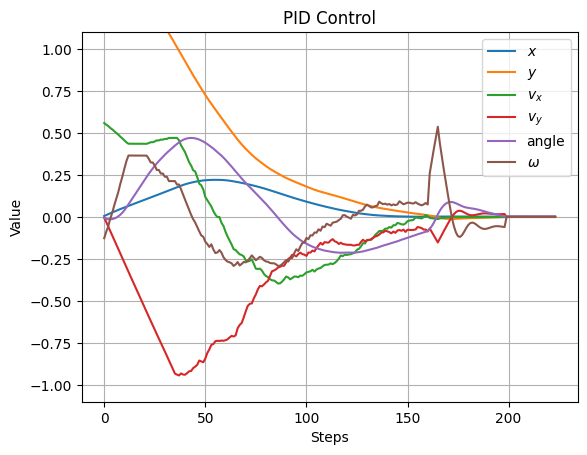

In [32]:
# plot check of the final results
def graph(states):
    """ Plot the value of the observation space quantities.

    Args:
        states (list): list of 300 lists in which any list is
        an 8-element list of the current space.
    """
    states_reshaped = np.array(states).reshape(len(states),-1)
    plt.plot(states_reshaped[:,0],label='$x$')
    plt.plot(states_reshaped[:,1],label='$y$')
    plt.plot(states_reshaped[:,2],label='$v_x$')
    plt.plot(states_reshaped[:,3],label='$v_y$')
    plt.plot(states_reshaped[:,4],label='angle')
    plt.plot(states_reshaped[:,5],label='$\omega$')
    plt.legend()
    plt.grid()
    plt.ylim(-1.1,1.1)
    plt.title('PID Control')
    plt.ylabel('Value')
    plt.xlabel('Steps')
    plt.show()

graph(state_list)
    
